In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ricardosalvatorelli1/paddydoctor")

print("Path to dataset files:", path)


100%|██████████| 1.02G/1.02G [00:46<00:00, 23.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1


In [2]:
import os
import shutil
from pathlib import Path

# Paths
source_folder = '/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images'  # Replace with your source dataset folder
destination_folder ="test_images"
images_per_class = 50  # Number of images to copy per class

# Create the destination folder
os.makedirs(destination_folder, exist_ok=True)

# Iterate through each class folder
for class_name in os.listdir(source_folder):
    class_path = os.path.join(source_folder, class_name)
    if os.path.isdir(class_path):  # Check if it's a folder
        # Create a corresponding folder in the destination
        dest_class_folder = os.path.join(destination_folder, class_name)
        os.makedirs(dest_class_folder, exist_ok=True)

        # Get all image files in the class folder
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        # Sort images to maintain order and select the first 50
        selected_images = images[:images_per_class]

        # Copy selected images to the destination folder
        for img_name in selected_images:
            src = os.path.join(class_path, img_name)
            dest = os.path.join(dest_class_folder, img_name)
            shutil.copy(src, dest)

print(f"Test dataset created successfully in '{destination_folder}'")


Test dataset created successfully in 'test_images'


In [3]:
train_path = '/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images'
test_path  = "test_images"

!du --inodes '/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images'
!du --inodes "test_images"

import glob
from pathlib import Path

for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

files = glob.glob(test_path + '/*')
print(f"{len(files)} \t {Path(test_path).name}")

1739	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/blast
338	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/bacterial_panicle_blight
966	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/brown_spot
1089	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/tungro
1765	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/normal
1443	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/dead_heart
381	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/bacterial_leaf_streak
1595	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/hispa
480	/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/bacterial_leaf_blight
621	/root/.cache/kagglehub/datasets/ricar

In [4]:
import numpy as np
import pandas as pd
import pickle
import cv2
import os

from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import keras
keras.__version__
from psutil import virtual_memory

SEED = 123
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
width = 256
height = 256
depth = 3

n_classes = len(glob.glob(train_path + '/*/'))
print(n_classes)

10


In [5]:
def get_model():
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    print(K.image_data_format())
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1
    model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(n_classes))
    model.add(Activation("softmax"))

    opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
    # distribution
    model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
    return model
model = get_model()

# plot_model(model, '/kaggle/working/model.png', show_shapes=True)

channels_last


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [6]:
image_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 shear_range=0.2,
                 zoom_range=0.2,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1./255,
                                   validation_split=0.2)

train_generator = image_datagen.flow_from_directory(
    directory = train_path,
    subset='training',
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=SEED)

valid_generator = image_datagen.flow_from_directory(
    directory=train_path,
    subset='validation',
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=SEED)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=test_path,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    classes=['.'],
    class_mode=None,
    shuffle=False,
    seed=SEED)

print(train_generator.class_indices)
print(test_generator.samples)

Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.
Found 500 images belonging to 1 classes.
{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}
500


In [7]:
%%time
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
history = model.fit(train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = STEP_SIZE_VALID,
                    epochs=EPOCHS)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


260/260 ━━━━━━━━━━━━━━━━━━━━ 213s 740ms/step - accuracy: 0.2586 - loss: 0.5438 - val_accuracy: 0.0835 - val_loss: 0.5984
Epoch 2/100
  1/260 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step - accuracy: 0.1875 - loss: 0.4161

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1875 - loss: 0.4161 - val_accuracy: 0.0690 - val_loss: 1.6241
Epoch 3/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 182s 688ms/step - accuracy: 0.3291 - loss: 0.3552 - val_accuracy: 0.3862 - val_loss: 0.3125
Epoch 4/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6250 - loss: 0.2246 - val_accuracy: 0.3103 - val_loss: 0.3292
Epoch 5/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 203s 690ms/step - accuracy: 0.4774 - loss: 0.2720 - val_accuracy: 0.4873 - val_loss: 0.2584
Epoch 6/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5000 - loss: 0.2837 - val_accuracy: 0.5172 - val_loss: 0.2595
Epoch 7/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 182s 687ms/step - accuracy: 0.5789 - loss: 0.2223 - val_accuracy: 0.4990 - val_loss: 0.2612
Epoch 8/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5312 - loss: 0.2423 - val_accuracy: 0.6207 - val_loss: 0.2476
Epoch 9/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 182s 688ms/step - accuracy: 0.6228 - loss: 0.2024 - val

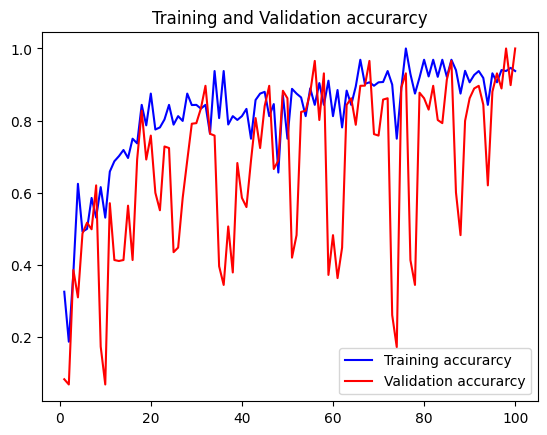

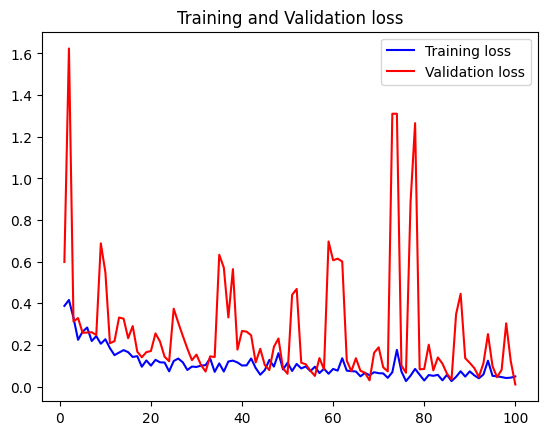

CPU times: user 458 ms, sys: 178 ms, total: 636 ms
Wall time: 491 ms


In [8]:
%%time
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [9]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred = model.predict(test_generator,
                               steps=STEP_SIZE_TEST,
                               verbose=1)

500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


In [10]:
loss, acc = model.evaluate(valid_generator, steps=STEP_SIZE_TEST, verbose=1)
print(acc, loss)

500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 75ms/step - accuracy: 0.9026 - loss: 0.2179  
0.9027443528175354 0.22487500309944153


In [11]:
pd.Series(train_generator.classes).value_counts()

,count
8,1412
3,1391
7,1276
5,1154
9,871
4,772
6,496
0,384
1,304
2,270


In [12]:
pd.Series(test_generator.classes).value_counts()

,count
0,500


In [13]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

pd.Series(predictions).value_counts()

,count
normal,53
blast,53
bacterial_leaf_blight,52
bacterial_panicle_blight,52
brown_spot,50
hispa,50
bacterial_leaf_streak,49
tungro,49
dead_heart,46
downy_mildew,46


In [14]:
filenames=test_generator.filenames

results=pd.DataFrame({"image_id":filenames,
                      "label":predictions})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("submission.csv",index=False)
results.head()

,image_id,label
0,bacterial_leaf_blight/100582.jpg,bacterial_leaf_blight
1,bacterial_leaf_blight/100681.jpg,bacterial_leaf_blight
2,bacterial_leaf_blight/100956.jpg,bacterial_leaf_blight
3,bacterial_leaf_blight/101394.jpg,bacterial_leaf_blight
4,bacterial_leaf_blight/101485.jpg,bacterial_leaf_blight
